# 고양이, 개 분류 - CNN v2
- Dropout 추가

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:24:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   234MB/s    in 0.3s    

2022-01-18 02:24:01 (234 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip cats_and_dogs_filtered > /dev/null

- 데이터 탐색

In [ ]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [ ]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg']


In [ ]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

* 모델 구성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [ ]:
model = Sequential([
                    Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu'),
                    MaxPool2D(),
                    Dropout(0.25),
                    Conv2D(32, (3, 3), activation = 'relu'),
                    MaxPool2D(),
                    Dropout(0.25),
                    Conv2D(64, (3, 3), activation = 'relu'),
                    MaxPool2D(),
                    Dropout(0.25),
                    Flatten(),
                    Dense(512, activation = 'relu'),
                    Dropout(0.5),
                    Dense(1, activation = 'sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

* 모델 설정

In [ ]:
from tensorflow.keras.optimizers import RMSprop     # 이렇게 할 경우 learning rate을 줄 수 있다

model.compile(
    optimizer = RMSprop(learning_rate=0.001, decay = 1e-8), # decay : 한 번 학습할 때마다 학습률을 (1/1000 * 1/1억)만큼 감소시키겠다
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

* 파일에서 이미지 데이터 읽어오는 방법

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)    # 정규화
test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150)   # 모델 설정에서 150 * 150으로 넣기로 함
)                                                                                 # class_mode = 'binary'넣어서 고양이는 0, 개는 1로 분류

validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* callback 정의

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only = True, verbose = 1)
early_stop = EarlyStopping(patience = 10)

- 모델 실행

In [ ]:
hist = model.fit(
    train_generator,        # X, y에 train_generator
    validation_data = validation_generator,
    epochs = 100,
    steps_per_epoch = 100,      # 한번의 epoch에서 훈련에 사용할 batch의 갯수       20 * 100 = 2000
    validation_steps = 50,      # 한번의 epoch가 끝났을 때, test에 사용되는 batch의 갯수    20 * 50 = 1000
    verbose = 2,
    callbacks = [checkpoint, early_stop],
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.67332, saving model to best-cat-dog-v2.h5
100/100 - 20s - loss: 0.7461 - accuracy: 0.5385 - val_loss: 0.6733 - val_accuracy: 0.5920 - 20s/epoch - 199ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.67332 to 0.62565, saving model to best-cat-dog-v2.h5
100/100 - 9s - loss: 0.6540 - accuracy: 0.6165 - val_loss: 0.6256 - val_accuracy: 0.6580 - 9s/epoch - 88ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.62565 to 0.61523, saving model to best-cat-dog-v2.h5
100/100 - 9s - loss: 0.6155 - accuracy: 0.6620 - val_loss: 0.6152 - val_accuracy: 0.6750 - 9s/epoch - 88ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.61523 to 0.57394, saving model to best-cat-dog-v2.h5
100/100 - 9s - loss: 0.5822 - accuracy: 0.6960 - val_loss: 0.5739 - val_accuracy: 0.7070 - 9s/epoch - 88ms/step
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.57394
100/100 - 9s - loss: 0.5442 - accuracy: 0.7375 - val_loss: 0.6130 - val_a

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [ ]:
from google.colab import files

up = files.upload()

Saving cat1.jfif to cat1.jfif
Saving cat2.jfif to cat2.jfif
Saving cat3.jfif to cat3.jfif
Saving cat4.jfif to cat4.jfif
Saving dog1.jfif to dog1.jfif
Saving dog2.jfif to dog2.jfif
Saving dog3.jfif to dog3.jfif
Saving dog4.jfif to dog4.jfif


In [ ]:
best_model.predict(img.reshape(-1, 150, 150, 3))

# 개일 확률을 계산(고양이가 class 0, 개가 class 1)

array([[1.]], dtype=float32)

In [ ]:
up.keys()

dict_keys(['cat1.jfif', 'cat2.jfif', 'cat3.jfif', 'cat4.jfif', 'dog1.jfif', 'dog2.jfif', 'dog3.jfif', 'dog4.jfif'])

In [ ]:
for fname in up.keys():
    img = cv2.imread(fname)[:, :, ::-1]
    if sum(img.shape[:-1]) > 300:           # 150 * 150보다 큰 이미지
        img = cv2.resize(img, dsize=(150, 150), interpolation = cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150, 150), interpolation = cv2.INTER_CUBIC)    # 작은 것을 늘릴때는 cv2.INTER_CUBIC을 쓴다
    classes = best_model.predict(img.reshape(-1, 150, 150, 3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0000 cat1.jfif is a cat
0.0000 cat2.jfif is a cat
0.0000 cat3.jfif is a cat
1.0000 cat4.jfif is a dog
1.0000 dog1.jfif is a dog
1.0000 dog2.jfif is a dog
1.0000 dog3.jfif is a dog
1.0000 dog4.jfif is a dog


* 학습과정 시각화

In [ ]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

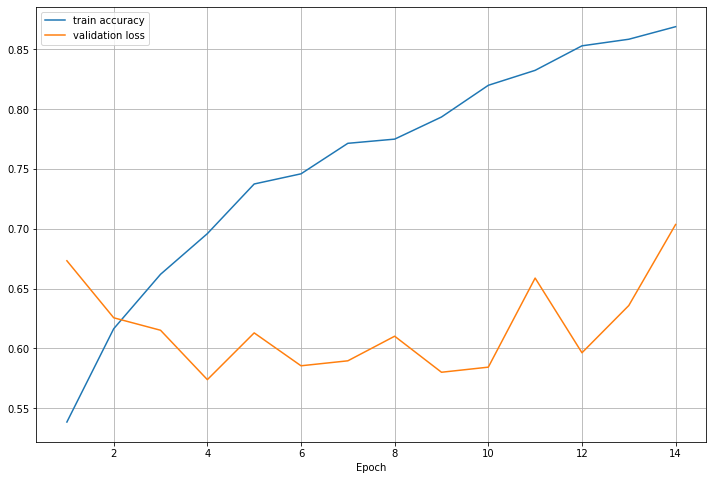

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(xs, y_acc, label = 'train accuracy')
plt.plot(xs, y_vloss, label = 'validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()